In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.momentum import StochasticOscillator
from ta.trend import EMAIndicator
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Pakai python versi 3.12 kalo mau run karena python versi 3.13 engga bisa import tensorflow (Serius gw engga boong)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional, LayerNormalization, LSTM
from tensorflow.keras.optimizers import Adam

In [19]:
ticker = "BBCA.JK"  
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

df = yf.download(ticker, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
Date,,,,,
2020-01-02,6000.032227,6080.750149,5991.063569,6004.516556,49445000
2020-01-03,6098.687988,6098.687988,6031.423047,6053.844694,47755500
2020-01-06,6040.391602,6053.844590,6000.032638,6026.938614,27300000
2020-01-07,6044.875488,6071.781462,6035.906830,6040.391159,45022500
2020-01-08,5991.063477,6049.359753,5982.094819,5982.094819,53692500


In [20]:
df.reset_index(inplace=True)
df.columns = df.columns.droplevel('Ticker')
df.columns.name = None 
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,6000.032227,6080.750149,5991.063569,6004.516556,49445000
1,2020-01-03,6098.687988,6098.687988,6031.423047,6053.844694,47755500
2,2020-01-06,6040.391602,6053.844590,6000.032638,6026.938614,27300000
3,2020-01-07,6044.875488,6071.781462,6035.906830,6040.391159,45022500
4,2020-01-08,5991.063477,6049.359753,5982.094819,5982.094819,53692500


In [21]:
MA100 = df['Close'].rolling(window=100).mean()
MA200 = df['Close'].rolling(window=200).mean()
MA50 = df['Close'].rolling(window=50).mean()

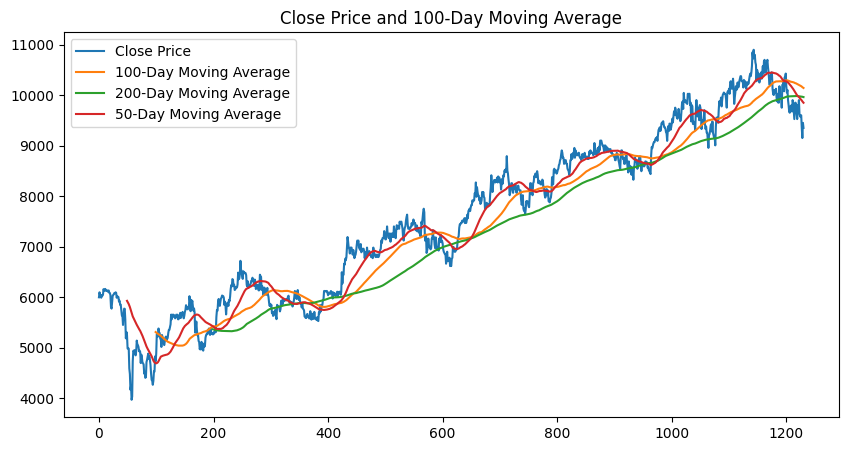

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price')
plt.plot(MA100, label='100-Day Moving Average')
plt.plot(MA200, label='200-Day Moving Average')
plt.plot(MA50, label='50-Day Moving Average')
plt.title('Close Price and 100-Day Moving Average')
plt.legend()
plt.show()

In [23]:
 # RSI
df['RSI'] = RSIIndicator(close=df['Close']).rsi()
 # MACD
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df.head()

,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal
0,2020-01-02,6000.032227,6080.750149,5991.063569,6004.516556,49445000,NaN,NaN,NaN
1,2020-01-03,6098.687988,6098.687988,6031.423047,6053.844694,47755500,NaN,NaN,NaN
2,2020-01-06,6040.391602,6053.844590,6000.032638,6026.938614,27300000,NaN,NaN,NaN
3,2020-01-07,6044.875488,6071.781462,6035.906830,6040.391159,45022500,NaN,NaN,NaN
4,2020-01-08,5991.063477,6049.359753,5982.094819,5982.094819,53692500,NaN,NaN,NaN


In [24]:
df.dropna(inplace=True)
df.head()

,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal
33,2020-02-18,6004.516602,6026.938247,5982.094956,5995.547943,98436500,46.588641,-4.788360,-6.059109
34,2020-02-19,6004.516602,6062.812879,5977.610627,5977.610627,74594000,46.588641,-6.853491,-6.217985
35,2020-02-20,5914.830078,6004.516660,5887.924104,6000.032331,136724500,39.240585,-15.547850,-8.083958
36,2020-02-21,5932.767578,5973.126541,5914.830261,5919.314590,98261000,41.236844,-20.751574,-10.617481
37,2020-02-24,5852.050293,5919.315239,5838.597304,5887.924931,84910000,35.572979,-31.031067,-14.700198


In [25]:
# Membuat fungsi untuk menghasilkan sinyal trading
def generate_trading_signals(df):
    # Inisialisasi kolom sinyal
    df['Signal'] = 'Hold'
    
    # Membuat sinyal berdasarkan RSI
    df.loc[df['RSI'] < 30, 'RSI_Signal'] = 'Buy'
    df.loc[df['RSI'] > 70, 'RSI_Signal'] = 'Sell'
    df.loc[(df['RSI'] >= 30) & (df['RSI'] <= 70), 'RSI_Signal'] = 'Hold'
    
    # Menyimpan MACD Signal Line original
    df['MACD_Signal_Line'] = df['MACD_Signal']  # Menyimpan garis sinyal MACD asli
    
    # Membuat sinyal berdasarkan MACD
    df['MACD_Cross'] = np.where(df['MACD'] > df['MACD_Signal_Line'], 1, -1)
    df['MACD_Signal_Change'] = df['MACD_Cross'].diff()
    
    df.loc[df['MACD_Signal_Change'] > 0, 'MACD_Signal'] = 'Buy'
    df.loc[df['MACD_Signal_Change'] < 0, 'MACD_Signal'] = 'Sell'
    df.loc[df['MACD_Signal_Change'] == 0, 'MACD_Signal'] = 'Hold'
    
    # Kombinasi sinyal RSI dan MACD
    conditions = [
        # Strong Buy: RSI oversold dan MACD memberikan sinyal beli
        (df['RSI_Signal'] == 'Buy') & (df['MACD_Signal'] == 'Buy'),
        # Strong Sell: RSI overbought dan MACD memberikan sinyal jual
        (df['RSI_Signal'] == 'Sell') & (df['MACD_Signal'] == 'Sell'),
        # Buy: Salah satu indikator memberikan sinyal beli
        ((df['RSI_Signal'] == 'Buy') & (df['MACD_Signal'] == 'Hold')) |
        ((df['RSI_Signal'] == 'Hold') & (df['MACD_Signal'] == 'Buy')),
        # Sell: Salah satu indikator memberikan sinyal jual
        ((df['RSI_Signal'] == 'Sell') & (df['MACD_Signal'] == 'Hold')) |
        ((df['RSI_Signal'] == 'Hold') & (df['MACD_Signal'] == 'Sell'))
    ]
    
    choices = ['Strong Buy', 'Strong Sell', 'Buy', 'Sell']
    df['Signal'] = np.select(conditions, choices, default='Hold')
    
    return df

# Manggil fungsi yag ada diats
df = generate_trading_signals(df)


C:\Users\user\AppData\Local\Temp\ipykernel_23708\3222069365.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['MACD_Signal_Change'] > 0, 'MACD_Signal'] = 'Buy'


In [26]:
# Fungsi untuk menambahkan indikator teknikal
def add_technical_indicators(df):
    
    # Bollinger Bands
    bb = BollingerBands(df['Close'])
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_middle'] = bb.bollinger_mavg()
    df['BB_lower'] = bb.bollinger_lband()
    
    # Stochastic Oscillator
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()
    
    # EMA
    ema20 = EMAIndicator(df['Close'], window=20)
    ema50 = EMAIndicator(df['Close'], window=50)
    df['EMA20'] = ema20.ema_indicator()
    df['EMA50'] = ema50.ema_indicator()
    
    return df

# Manggil fungsi yang ada diatas
df = add_technical_indicators(df)


In [27]:
df.dropna(inplace=True)
df.head()


,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,Signal,...,MACD_Signal_Line,MACD_Cross,MACD_Signal_Change,BB_upper,BB_middle,BB_lower,Stoch_K,Stoch_D,EMA20,EMA50
82,2020-04-29,4424.995117,4424.995117,4379.376611,4402.185864,121161000,35.040217,-150.549525,Hold,Hold,...,-120.624479,-1,0.0,5229.366898,4803.379956,4377.393014,6.263918,6.205109,4722.548877,5017.807987
83,2020-04-30,4716.953613,4789.943224,4452.366273,4452.366273,174081000,47.454217,-132.766755,Hold,Hold,...,-123.052934,-1,0.0,5217.848530,4793.486377,4369.124224,50.386243,19.933954,4722.015995,5006.009777
84,2020-05-04,4762.572754,4835.562375,4561.851297,4698.706836,114497500,49.091297,-113.682240,Buy,Buy,...,-121.178795,1,2.0,5212.697235,4789.012793,4365.328351,57.195288,37.948483,4725.878543,4996.463227
85,2020-05-05,4821.876465,4872.056825,4744.324999,4762.572402,118643500,51.218959,-92.703680,Hold,Hold,...,-115.483772,1,0.0,5202.897147,4783.692725,4364.488302,66.046872,57.876134,4735.021203,4989.616687
86,2020-05-06,4885.742676,4899.428229,4835.562312,4849.247866,86395500,53.474127,-70.116294,Hold,Hold,...,-106.410276,1,0.0,5159.718435,4770.803589,4381.888742,88.630439,70.624200,4749.375629,4985.543196


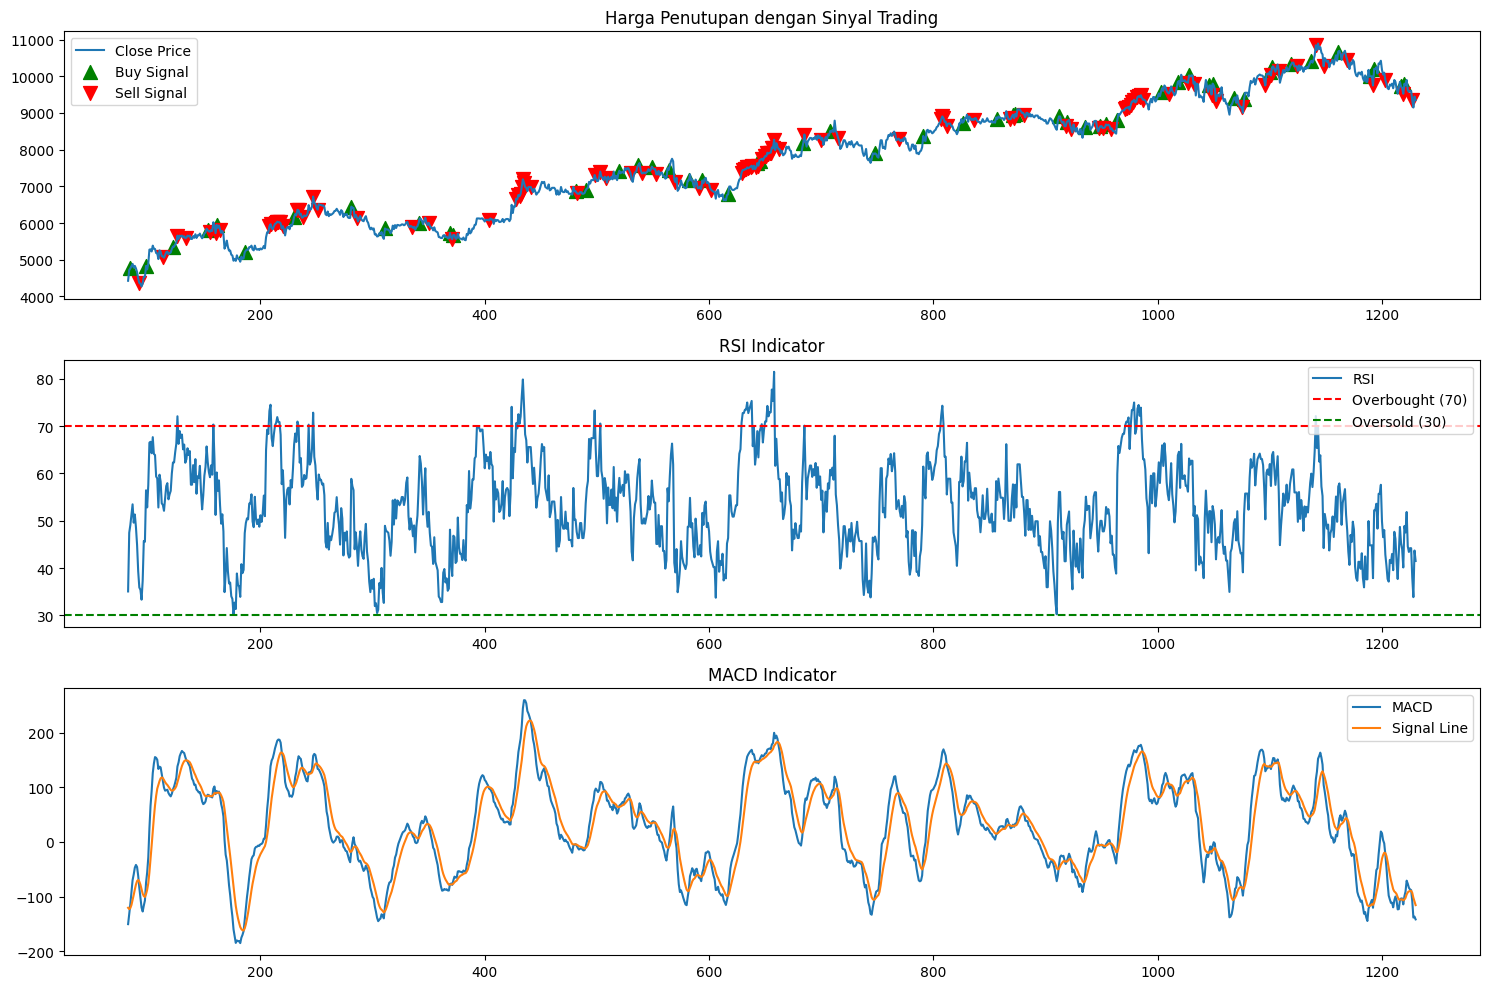

In [28]:
# Visualisasi
plt.figure(figsize=(15, 10))

# Plot close price
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Harga Penutupan dengan Sinyal Trading')

# Menambahkan marker untuk sinyal
buy_signals = df[df['Signal'].isin(['Buy', 'Strong Buy'])]
sell_signals = df[df['Signal'].isin(['Sell', 'Strong Sell'])]

plt.scatter(buy_signals.index, buy_signals['Close'], 
           marker='^', color='g', label='Buy Signal', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], 
           marker='v', color='r', label='Sell Signal', s=100)
plt.legend()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.title('RSI Indicator')
plt.legend()

# Plot MACD
plt.subplot(3, 1, 3)
plt.plot(df.index, df['MACD'], label='MACD')
plt.plot(df.index, df['MACD_Signal_Line'], label='Signal Line')  # Menggunakan MACD_Signal_Line
plt.title('MACD Indicator')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
print("\nStatistik Sinyal Trading:")
print(df['Signal'].value_counts())

print("\nSinyal Trading Terakhir:")
print(df[['Close', 'RSI', 'MACD', 'MACD_Signal_Line', 'Signal']].tail())


Statistik Sinyal Trading:
Signal
Hold    983
Sell    113
Buy      53
Name: count, dtype: int64

Sinyal Trading Terakhir:
       Close        RSI        MACD  MACD_Signal_Line Signal
1226  9600.0  44.195798  -88.223954        -89.552517   Hold
1227  9350.0  37.953375 -108.172433        -93.276500   Sell
1228  9150.0  33.835953 -138.523265       -102.325853   Hold
1229  9450.0  43.702013 -136.792171       -109.219117   Hold
1230  9350.0  41.481567 -141.854223       -115.746138   Hold


In [30]:
# Persiapkan fitur (X) dan target (y) dimana kita fokus pake 2 indikator RSI sama MACD (biar lebih simple wkkwkw)
features = ['Close', 'RSI', 'MACD', 'MACD_Signal_Line']
X1 = df[features]
y1 = df['Signal']

# Konversi label kategorikal ke numerik
y1 = y1.map({'Buy': 1, 'Strong Buy': 1, 'Sell': 2, 'Strong Sell': 2, 'Hold': 0})

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [31]:
# Normalisasi data
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)


In [32]:
# 1. Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X1_train_scaled, y1_train)


RandomForestClassifier(random_state=42)

In [33]:
# Evaluasi model Random Forest
rf_predictions = rf_model.predict(X1_test_scaled)
print("\nHasil Evaluasi Model Random Forest:")
print(classification_report(y1_test, rf_predictions, target_names=['Hold', 'Buy', 'Sell']))



Hasil Evaluasi Model Random Forest:
              precision    recall  f1-score   support

        Hold       0.87      0.98      0.93       190
         Buy       1.00      0.08      0.15        12
        Sell       0.80      0.43      0.56        28

    accuracy                           0.87       230
   macro avg       0.89      0.50      0.55       230
weighted avg       0.87      0.87      0.84       230



In [34]:
# 2. Model Deep Learning (LSTM)
# Reshape data untuk LSTM (samples, time steps, features)
X1_train_lstm = X1_train_scaled.reshape((X1_train_scaled.shape[0], 1, X1_train_scaled.shape[1]))
X1_test_lstm = X1_test_scaled.reshape((X1_test_scaled.shape[0], 1, X1_test_scaled.shape[1]))

# Buat model LSTM
lstm_model = Sequential([
    LSTM(50, input_shape=(1, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas: Hold, Buy, Sell
])

# Compile model
lstm_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Training model
history = lstm_model.fit(X1_train_lstm, y1_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7341 - loss: 1.0725 - val_accuracy: 0.8804 - val_loss: 0.9781
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8592 - loss: 0.9400 - val_accuracy: 0.8804 - val_loss: 0.7582
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8576 - loss: 0.7038 - val_accuracy: 0.8804 - val_loss: 0.5000
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8614 - loss: 0.5106 - val_accuracy: 0.8804 - val_loss: 0.4295
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8446 - loss: 0.5079 - val_accuracy: 0.8804 - val_loss: 0.4147
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8490 - loss: 0.4843 - val_accuracy: 0.8804 - val_loss: 0.4027
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8570 - loss: 0.4539 - val_accuracy: 0.8804 - val_loss: 0.3984
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8638 - loss: 0.4264 - val_accuracy: 0.8804 - v

In [35]:
train_accuracy = history.history['accuracy'][-1]  # Final training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Final validation accuracy
train_loss = history.history['loss'][-1]  # Final training loss
val_loss = history.history['val_loss'][-1]  # Final validation loss

y_pred_lstm = lstm_model.predict(X1_test_lstm)
y_pred_classes = np.argmax(y_pred_lstm, axis=1)



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step



LSTM Model Evaluation:
Final Training Accuracy: 0.9020
Final Validation Accuracy: 0.9076
Final Training Loss: 0.3294
Final Validation Loss: 0.3241

Detailed Classification Report:
              precision    recall  f1-score   support

        Hold       0.87      0.99      0.93       190
         Buy       0.00      0.00      0.00        12
        Sell       0.80      0.43      0.56        28

    accuracy                           0.87       230
   macro avg       0.56      0.47      0.50       230
weighted avg       0.82      0.87      0.83       230



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

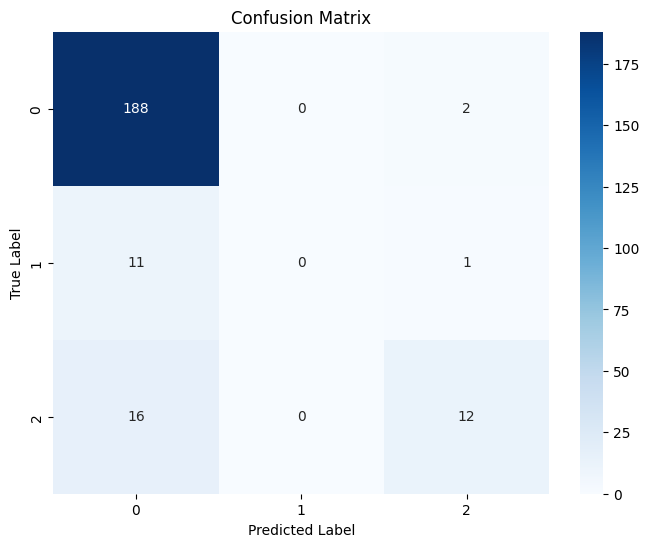

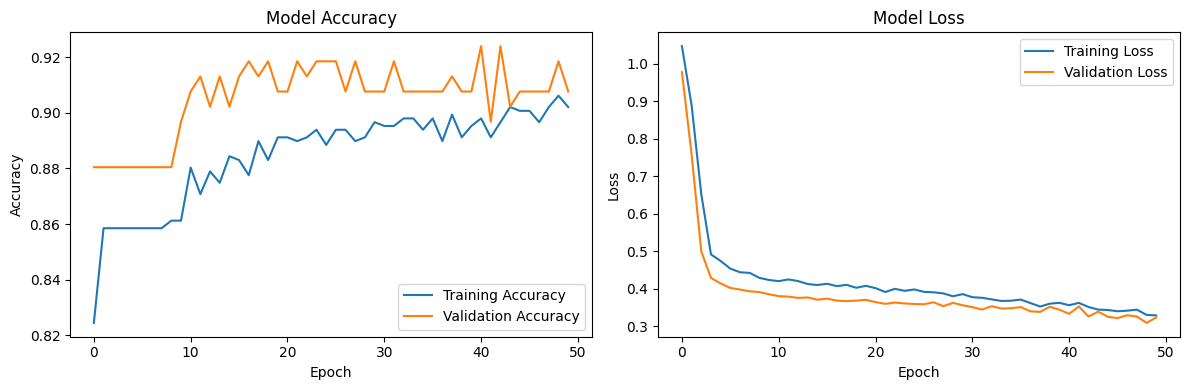

In [36]:

from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM Model Evaluation:")
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y1_test, y_pred_classes, target_names=['Hold', 'Buy', 'Sell']))

# 4. Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y1_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
features2 = [
    'Close', 'RSI', 'MACD', 'MACD_Signal_Line',
    'BB_upper', 'BB_lower', 'BB_middle',
    'Stoch_K', 'Stoch_D', 'EMA20', 'EMA50'
]

In [38]:
def prepare_price_prediction_data(df, features, lookback=60):  
    price_scaler = RobustScaler()  
    feature_scaler = RobustScaler()
    
    df_clean = df[features].copy()
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    
    # Normalisasi data
    prices_scaled = price_scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    features_scaled = feature_scaler.fit_transform(df_clean)
    
    X, y = [], []
    for i in range(lookback, len(df)):
        
        sequence = features_scaled[i-lookback:i]
        
       
        stats = np.array([
            np.mean(sequence, axis=0),
            np.std(sequence, axis=0),
            np.min(sequence, axis=0),
            np.max(sequence, axis=0)
        ])
        
      
        enriched_sequence = np.vstack([sequence, stats])
        X.append(enriched_sequence)
        y.append(prices_scaled[i])
    
    X, y = np.array(X), np.array(y)
    
    
    X_aug, y_aug = data_augmentation(X, y)
    
    return X_aug, y_aug, price_scaler, feature_scaler

In [39]:
def data_augmentation(X, y):
    X_aug, y_aug = X.copy(), y.copy()
    
   
    noise_factor = 0.002
    X_noise = X + np.random.normal(0, noise_factor, X.shape)
    y_noise = y + np.random.normal(0, noise_factor/2, y.shape)
    
    X_aug = np.concatenate([X_aug, X_noise])
    y_aug = np.concatenate([y_aug, y_noise])
    
    return X_aug, y_aug

In [40]:
def build_improved_gru_model(input_shape):
    model = Sequential([
        # Input layer dengan normalisasi
        LayerNormalization(),
        
        # First GRU layer
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.3),
        LayerNormalization(),
        
        # Second GRU layer
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.3),
        LayerNormalization(),
        
        # Third GRU layer
        Bidirectional(GRU(32)),
        Dropout(0.2),
        LayerNormalization(),
        
        # Dense layers
        Dense(32, activation='swish'),
        Dropout(0.2),
        Dense(16, activation='swish'),
        Dense(1)
    ])
    
    # Gunakan optimizer dengan learning rate tetap
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(delta=1.0),  # Huber loss untuk ketahanan terhadap outlier
        metrics=['mae', 'mse']
    )
    
    return model

# Callbacks yang lebih sophisticated
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=0.00001,
        mode='min'
    ),
    ModelCheckpoint(
        'best_gru_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
]

# Siapkan data
X, y, price_scaler, feature_scaler = prepare_price_prediction_data(df, features2)

# Split data dengan validasi
split = int(len(X) * 0.7)
val_split = int(len(X) * 0.85)
X_train, X_val, X_test = X[:split], X[split:val_split], X[val_split:]
y_train, y_val, y_test = y[:split], y[split:val_split], y[val_split:]

# Build dan train model
gru_model = build_improved_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    
    
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

C:\Users\user\AppData\Local\Temp\ipykernel_23708\3421533356.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 290ms/step - loss: 0.1502 - mae: 0.4141 - mse: 0.3263 - val_loss: 0.0158 - val_mae: 0.1353 - val_mse: 0.0316 - learning_rate: 0.0010
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - loss: 0.0304 - mae: 0.1932 - mse: 0.0608 - val_loss: 0.0163 - val_mae: 0.1446 - val_mse: 0.0326 - learning_rate: 0.0010
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - loss: 0.0226 - mae: 0.1688 - mse: 0.0451 - val_loss: 0.0085 - val_mae: 0.1060 - val_mse: 0.0169 - learning_rate: 0.0010
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - loss: 0.0194 - mae: 0.1551 - mse: 0.0388 - val_loss: 0.0060 - val_mae: 0.0894 - val_mse: 0.0120 - learning_rate: 0.0010
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - loss: 0.0158 - mae: 0.1401 - mse: 0.0316 - val_loss: 0.0033 - val_mae: 0.0656 - val_mse: 0.0066 - learning_rate: 0.0010
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - loss: 0.0147 - mae: 0.1344 - mse: 0.0294 - val_loss: 0.0029 - va

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step

Hasil Evaluasi Model:
R-squared (R²) Score: 0.8983
Root Mean Squared Error (RMSE): 196.29
Mean Absolute Error (MAE): 154.11
Mean Absolute Percentage Error (MAPE): 1.57%


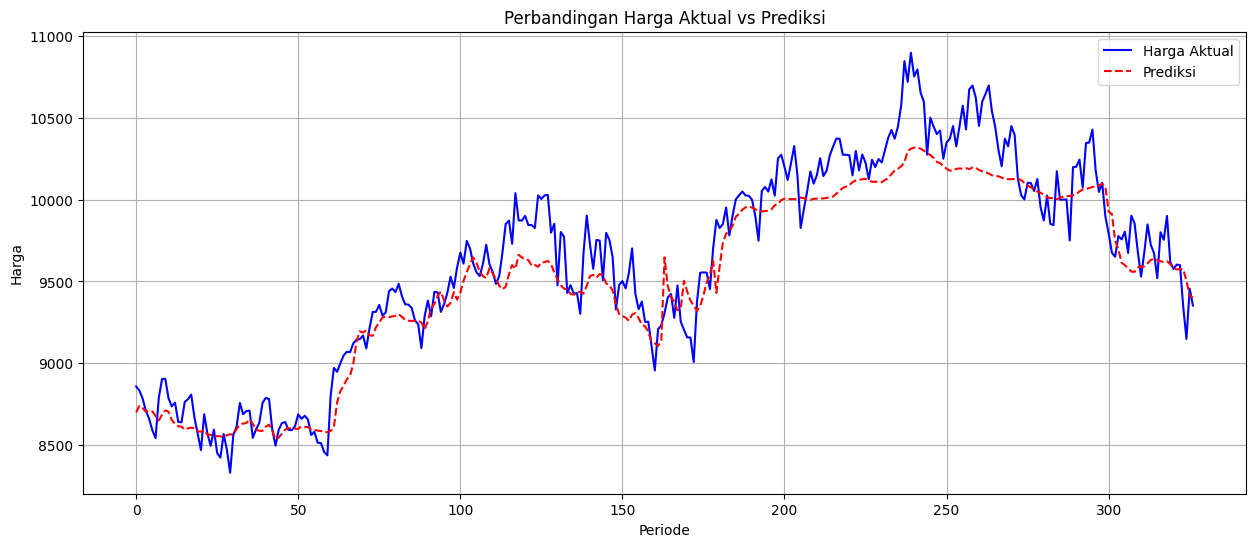

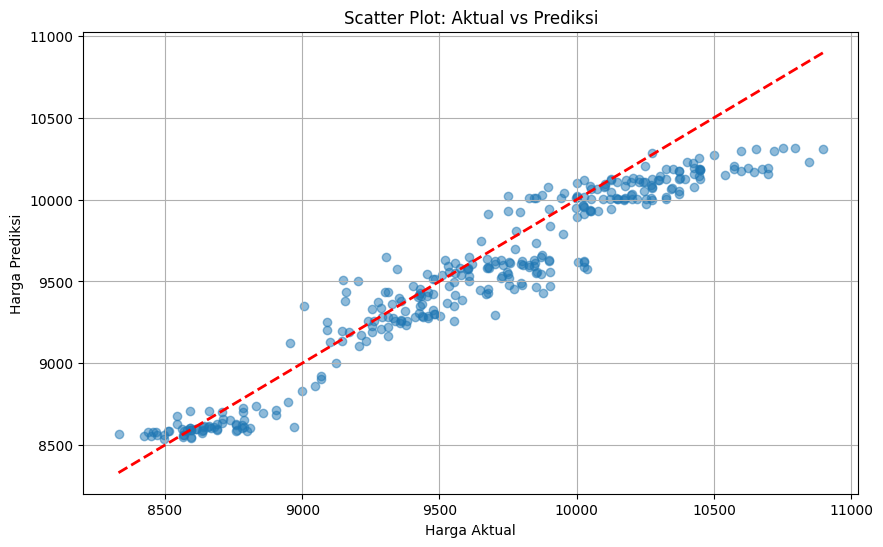

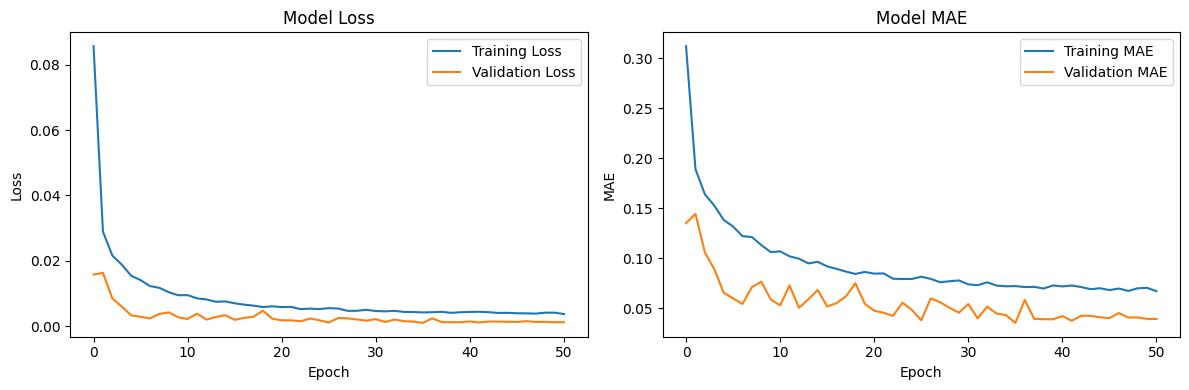

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


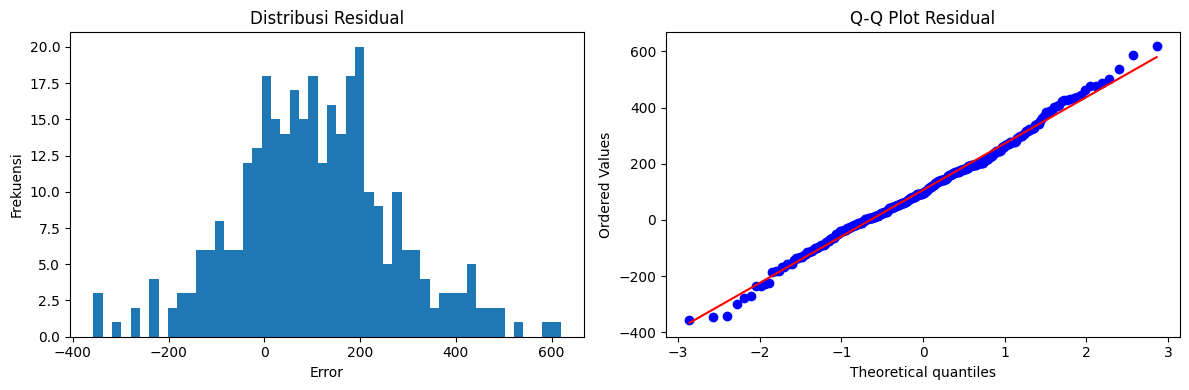


Interpretasi Hasil:
- Model dapat menjelaskan 89.83% variasi dalam data
- Rata-rata error absolut adalah 154.11 poin
- Error persentase rata-rata adalah 1.57%


In [41]:
def evaluate_model(model, X_test, y_test, price_scaler):
    # Prediksi
    y_pred = model.predict(X_test)
    
    # Inverse transform untuk mendapatkan nilai harga asli
    y_test_original = price_scaler.inverse_transform(y_test)
    y_pred_original = price_scaler.inverse_transform(y_pred)
    
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    # Hitung MAPE 
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    
    print("\nHasil Evaluasi Model:")
    print(f"R-squared (R²) Score: {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Visualisasi hasil prediksi
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_original, label='Harga Aktual', color='blue')
    plt.plot(y_pred_original, label='Prediksi', color='red', linestyle='--')
    plt.title('Perbandingan Harga Aktual vs Prediksi')
    plt.xlabel('Periode')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2)
    plt.xlabel('Harga Aktual')
    plt.ylabel('Harga Prediksi')
    plt.title('Scatter Plot: Aktual vs Prediksi')
    plt.grid(True)
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }

# Import metrik yang diperlukan
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Jalankan evaluasi
metrics = evaluate_model(gru_model, X_test, y_test, price_scaler)

# Analisis residual
residuals = (price_scaler.inverse_transform(y_test) - 
            price_scaler.inverse_transform(gru_model.predict(X_test))).flatten()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50)
plt.title('Distribusi Residual')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Residual')

plt.tight_layout()
plt.show()

# Print interpretasi hasil
print("\nInterpretasi Hasil:")
print(f"- Model dapat menjelaskan {metrics['r2']*100:.2f}% variasi dalam data")
print(f"- Rata-rata error absolut adalah {metrics['mae']:.2f} poin")
print(f"- Error persentase rata-rata adalah {metrics['mape']:.2f}%")

In [42]:
import joblib

# Simpan model Random Forest
joblib.dump(rf_model, 'models/random_forest_model_sahamlocal.joblib')
    
# Simpan model LSTM dengan custom_objects
lstm_model.save('models/lstm_model_sahamlocal.h5', save_format='h5')
    
# Simpan model GRU dengan custom_objects
gru_model.save('models/gru_model_sahamlocal.keras', save_format='keras')  
    

# Simpan semua scaler
joblib.dump(scaler, 'models/scaler_sahamlocal.joblib')
joblib.dump(price_scaler, 'models/price_scaler_sahamlocal.joblib')
joblib.dump(feature_scaler, 'models/feature_scaler_sahamlocal.joblib')

['models/feature_scaler_sahamlocal.joblib']